<a href="https://colab.research.google.com/github/HanifFaishalH/Kuis2_KlasifikasiJenisBatik/blob/main/Kuis2_Batik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# 1. Preprocessing Data Batik

augmentasi data > 1 gambar menjadi 4 gambar (1 gambar asli + 3 gambar hasil augmentasi)
Image enhancement → contras/brightness correction, noise removal, glare removal, etc.

In [2]:
!pip install albumentations==1.3.1 opencv-python tqdm

import cv2
import numpy as np
import albumentations as A
from pathlib import Path
from google.colab import files
from tqdm import tqdm

input_folder = ('/content/drive/MyDrive/batik_dataset/Batik300')
output_folder = ('/content/drive/MyDrive/batik_dataset/batik_aug')
copies_per_image = 3
img_size = 512

Path(output_folder).mkdir(parents=True, exist_ok=True)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.7),
    A.Rotate(limit=30, p=0.5),
])

image_files = sorted([
    p for p in Path(input_folder).glob("*")
    if p.suffix.lower() in [".jpg", ".jpeg", ".png"]
])

print(f"Total gambar batik-cap ditemukan: {len(image_files)}")
print(f"Memulai augmentasi (Total output: {len(image_files) * (copies_per_image + 1)} gambar)...")

for img_path in tqdm(image_files, desc="Augmentasi Gambar"):
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"Gagal membaca: {img_path.name}, skipping.")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    base_name = img_path.stem

    original_resized = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
    save_path_original = Path(output_folder) / f"{base_name}_original.jpg"
    cv2.imwrite(str(save_path_original), cv2.cvtColor(original_resized, cv2.COLOR_RGB2BGR))

    for i in range(copies_per_image):
        aug = transform(image=img)
        aug_img = aug["image"]

        if aug_img.dtype != np.uint8:
            aug_img = np.clip(aug_img, 0, 255).astype(np.uint8)

        aug_img = cv2.resize(aug_img, (img_size, img_size), interpolation=cv2.INTER_AREA)

        save_path = Path(output_folder) / f"{base_name}_aug_{i+1:02d}.jpg"
        cv2.imwrite(str(save_path), cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))

print("\nSelesai! Semua gambar batik-cap berhasil di-augment.")
print(f"Total gambar di folder output: {len(list(Path(output_folder).glob('*.jpg')))}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.8
    Uninstalling albumentations-2.0.8:
      Successfully uninstalled albumentations-2.0.8
Total gambar batik-cap ditemukan: 300
Memulai augmentasi (Total output: 1200 gambar)...


Augmentasi Gambar: 100%|██████████| 300/300 [00:28<00:00, 10.40it/s]


Selesai! Semua gambar batik-cap berhasil di-augment.
Total gambar di folder output: 1200


In [4]:
import cv2
import os
import numpy as np
from tqdm import tqdm

input_dir = '/content/drive/MyDrive/batik_dataset/batik_aug'
output_dir = '/content/drive/MyDrive/batik_dataset/batik-enhanced'
os.makedirs(output_dir, exist_ok=True)

def enhance_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None

    # 1. Contrast enhancement (CLAHE)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    enhanced = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    # 2. Brightness normalization
    hsv = cv2.cvtColor(enhanced, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.equalizeHist(v)
    hsv_enhanced = cv2.merge((h, s, v))
    enhanced = cv2.cvtColor(hsv_enhanced, cv2.COLOR_HSV2BGR)

    # 3. Noise removal (bilateral)
    denoised = cv2.bilateralFilter(enhanced, d=9, sigmaColor=75, sigmaSpace=75)

    # 4. Glare removal
    gray = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    glare_removed = cv2.inpaint(denoised, mask, 3, cv2.INPAINT_TELEA)

    return glare_removed

print("Melakukan enhancement gambar...")
for filename in tqdm(os.listdir(input_dir)):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)
        enhanced = enhance_image(input_path)
        if enhanced is not None:
            cv2.imwrite(output_path, enhanced)
print("Enhancement selesai! Hasil disimpan di:", output_dir)

Melakukan enhancement gambar...


100%|██████████| 1200/1200 [02:10<00:00,  9.20it/s]

Enhancement selesai! Hasil disimpan di: /content/drive/MyDrive/batik_dataset/batik-enhanced


# 2. Ekstraksi Fitur

Metode ekstraksi fitur yang digunakan terdiri dari tiga jenis, yaitu GLCM, LBP, dan HSV Histogram. Fitur ini diekstraksi dari setiap gambar batik untuk membedakan motif batik (misal parang, kawung, mega mendung, dsb.):

GLCM (Gray Level Co-occurrence Matrix) – menangkap tekstur motif, seperti rapat atau halus, melalui fitur contrast, dissimilarity, homogeneity, energy, correlation.

LBP (Local Binary Pattern) – menangkap pola lokal pada motif, misal garis, titik, atau pola berulang, menggunakan mean dan std histogram LBP.

HSV Histogram – menangkap ciri warna motif, seperti dominasi warna atau gradasi khas motif batik.

In [5]:
import cv2
import os
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern

# === Path input dan output ===
label_csv = '/content/drive/MyDrive/batik_dataset/batik300_labels.csv'
output_csv = '/content/drive/MyDrive/batik_dataset/batik_motif_features.csv'

# === Fungsi ekstraksi fitur ===
def extract_features(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None

    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # --- GLCM ---
    glcm = graycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast').mean()
    dissimilarity = graycoprops(glcm, 'dissimilarity').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    energy = graycoprops(glcm, 'energy').mean()
    correlation = graycoprops(glcm, 'correlation').mean()

    # --- LBP ---
    lbp = local_binary_pattern(gray, 8, 1, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 59))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    lbp_mean = hist.mean()
    lbp_std = hist.std()

    # --- HSV ---
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist_h = cv2.calcHist([hsv], [0], None, [8], [0, 180])
    hist_s = cv2.calcHist([hsv], [1], None, [8], [0, 256])
    hist_v = cv2.calcHist([hsv], [2], None, [8], [0, 256])
    color_features = np.concatenate([hist_h, hist_s, hist_v]).flatten()
    color_features /= (color_features.sum() + 1e-7)

    return np.hstack([
        [contrast, dissimilarity, homogeneity, energy, correlation],
        [lbp_mean, lbp_std],
        color_features
    ])

# === Ekstraksi fitur dari semua gambar ===
data = []
filenames = []

print("Mengekstraksi fitur dari semua citra di folder...")

for file in tqdm(os.listdir(input_dir)):
    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(input_dir, file)
        feats = extract_features(img_path)
        if feats is not None:
            data.append(feats)
            filenames.append(file)



Mengekstraksi fitur dari semua citra di folder...


100%|██████████| 1200/1200 [02:41<00:00,  7.45it/s]


## Mengekstraksi Semua Fitur dari Setiap Gambar dalam Folder Motif.

In [6]:
if len(data) == 0:
    print("Tidak ada citra valid di folder ini!")
else:
    # === Buat DataFrame fitur ===
    columns = [
        'contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation',
        'lbp_mean', 'lbp_std'
    ] + [f'color_{i+1}' for i in range(24)]  # 8 H + 8 S + 8 V

    features_df = pd.DataFrame(data, columns=columns)
    features_df['filename'] = filenames

    # === Baca file label ===
    labels_df = pd.read_csv(label_csv)

    # === Buat kolom prefix agar bisa dihubungkan ===
    features_df['prefix'] = features_df['filename'].apply(
        lambda x: re.match(r'(B\d+_\d+)', x).group(1) if re.match(r'(B\d+_\d+)', x) else None
    )
    labels_df['prefix'] = labels_df['filename'].apply(
        lambda x: re.match(r'(B\d+_\d+)', x).group(1) if re.match(r'(B\d+_\d+)', x) else None
    )

    # === Tambahkan kolom motif_name & region jika belum ada ===
    if 'motif_name' not in labels_df.columns or 'region' not in labels_df.columns:
        motif_mapping = {
            1: ('Parang', 'Yogyakarta'),
            2: ('Kawung', 'Yogyakarta'),
            3: ('Mega Mendung', 'Cirebon'),
            4: ('Ceplok', 'Solo'),
            5: ('Truntum', 'Solo'),
            6: ('Lereng', 'Pekalongan'),
            7: ('Lasem', 'Lasem'),
            8: ('Sekar Jagad', 'Solo'),
            9: ('Tambal', 'Yogyakarta'),
            10: ('Nitik', 'Yogyakarta'),
            11: ('Pamiluto', 'Pekalongan'),
            12: ('Sido Mukti', 'Solo'),
            13: ('Sido Luhur', 'Yogyakarta'),
            14: ('Sekar Arum', 'Pekalongan'),
            15: ('Grompol', 'Solo'),
            16: ('Wahyu Tumurun', 'Yogyakarta'),
            17: ('Cuwiri', 'Yogyakarta'),
            18: ('Gurda', 'Surakarta'),
            19: ('Singa Barong', 'Cirebon'),
            20: ('Gringsing', 'Bali'),
            21: ('Sida Asih', 'Yogyakarta'),
            22: ('Klithik', 'Solo'),
            23: ('Sido Drajat', 'Yogyakarta'),
            24: ('Udan Liris', 'Yogyakarta'),
            25: ('Sekar Kencana', 'Solo'),
            26: ('Sekar Melati', 'Pekalongan'),
            27: ('Bunga Teratai', 'Pekalongan'),
            28: ('Wahyu Nugraha', 'Solo'),
            29: ('Jlamprang', 'Pekalongan'),
            30: ('Sidoluhur', 'Yogyakarta'),
            31: ('Sida Mukti', 'Yogyakarta'),
            32: ('Sido Mulyo', 'Solo'),
            33: ('Merak Ngibing', 'Cirebon'),
            34: ('Lung-lungan', 'Yogyakarta'),
            35: ('Gurdo', 'Yogyakarta'),
            36: ('Alas-alasan', 'Banyumas'),
            37: ('Kembang Kantil', 'Solo'),
            38: ('Kembang Tanjung', 'Pekalongan'),
            39: ('Sekar Jagad', 'Yogyakarta'),
            40: ('Pisan Bali', 'Bali'),
            41: ('Sekar Sari', 'Solo'),
            42: ('Sido Mulyo', 'Yogyakarta'),
            43: ('Grompol', 'Solo'),
            44: ('Sidomukti', 'Yogyakarta'),
            45: ('Tambal', 'Yogyakarta'),
            46: ('Parang Klitik', 'Yogyakarta'),
            47: ('Sekar Mayang', 'Solo'),
            48: ('Sido Luhur', 'Yogyakarta'),
            49: ('Truntum', 'Solo'),
            50: ('Mega Mendung', 'Cirebon')
        }
        labels_df['motif_num'] = labels_df['motif_id'].apply(lambda x: int(x[1:]) if isinstance(x, str) and x.startswith('B') else None)
        labels_df['motif_name'] = labels_df['motif_num'].map(lambda x: motif_mapping.get(x, ('Unknown','Unknown'))[0])
        labels_df['region'] = labels_df['motif_num'].map(lambda x: motif_mapping.get(x, ('Unknown','Unknown'))[1])

    # === Merge label ke fitur ===
    merged_df = features_df.merge(
        labels_df[['prefix', 'motif_id', 'motif_name', 'region']],
        on='prefix',
        how='left'
    )

    merged_df.drop(columns=['prefix'], inplace=True)
    merged_df.to_csv(output_csv, index=False)

    print(f"Ekstraksi dan labeling selesai!")
    print(f"File disimpan di: {output_csv}")
    print("Total citra:", len(merged_df))
    print(merged_df[['filename', 'motif_id', 'motif_name', 'region']].head(10))

Ekstraksi dan labeling selesai!
File disimpan di: /content/drive/MyDrive/batik_dataset/batik_motif_features.csv
Total citra: 1200
             filename motif_id motif_name      region
0  B10_1_original.jpg      B10      Nitik  Yogyakarta
1    B10_1_aug_01.jpg      B10      Nitik  Yogyakarta
2    B10_1_aug_02.jpg      B10      Nitik  Yogyakarta
3    B10_1_aug_03.jpg      B10      Nitik  Yogyakarta
4  B10_2_original.jpg      B10      Nitik  Yogyakarta
5    B10_2_aug_01.jpg      B10      Nitik  Yogyakarta
6    B10_2_aug_02.jpg      B10      Nitik  Yogyakarta
7    B10_2_aug_03.jpg      B10      Nitik  Yogyakarta
8  B10_3_original.jpg      B10      Nitik  Yogyakarta
9    B10_3_aug_01.jpg      B10      Nitik  Yogyakarta


## Reduksi Dimensi dengan PCA

Data awal:
     contrast  dissimilarity  homogeneity    energy  correlation  lbp_mean  \
0  291.197891       7.830111     0.393831  0.039892     0.757231  0.017241   
1  112.821986       4.966842     0.444732  0.047760     0.842607  0.017241   
2  116.677590       5.086984     0.437240  0.046981     0.841163  0.017241   
3  291.197042       7.830095     0.393836  0.039892     0.757230  0.017241   
4  293.005137       7.846050     0.397358  0.039600     0.766583  0.017241   

    lbp_std   color_1  color_2  color_3  ...  color_19  color_20  color_21  \
0  0.044297  0.328887      0.0      0.0  ...  0.039247  0.179320  0.084415   
1  0.045425  0.330064      0.0      0.0  ...  0.028219  0.183694  0.107529   
2  0.045178  0.330050      0.0      0.0  ...  0.026262  0.181676  0.109936   
3  0.044297  0.328887      0.0      0.0  ...  0.039247  0.179321  0.084414   
4  0.044347  0.327662      0.0      0.0  ...  0.035786  0.173177  0.091212   

   color_22  color_23  color_24            filename

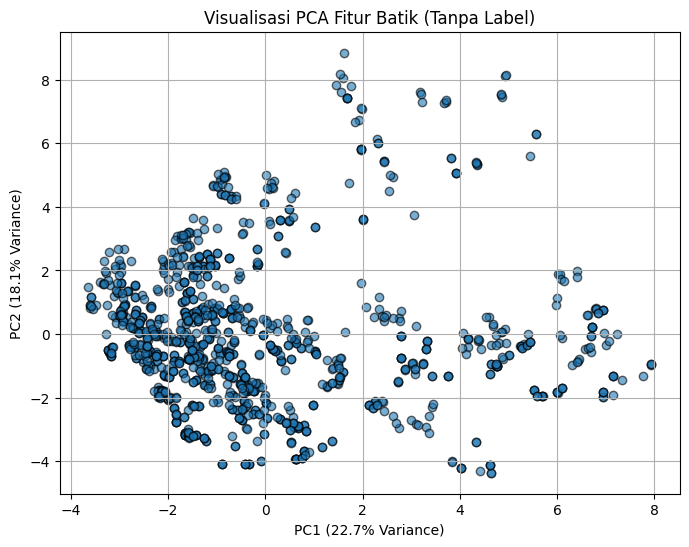

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Path file CSV fitur
csv_path = '/content/drive/MyDrive/batik_dataset/batik_motif_features.csv'

# Baca dataset
df = pd.read_csv(csv_path)
print("Data awal:")
print(df.head())
print(df.isnull().sum())

# Pisahkan kolom non-fitur (misal 'filename') jika ada
non_feature_cols = [col for col in df.columns if not col.startswith(('contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'lbp_', 'color_'))]
print(f"Kolom non-fitur dihapus: {non_feature_cols}")

X = df.drop(columns=non_feature_cols, errors='ignore')


# Standarisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Data berhasil distandarisasi. Ukuran: {X_scaled.shape}")


# PCA (Reduksi Dimensi)
pca = PCA(n_components=2)  # ambil 2 komponen utama untuk visualisasi
X_pca = pca.fit_transform(X_scaled)

print("Variance ratio tiap komponen:", pca.explained_variance_ratio_)
print(f"Total variance yang dijelaskan: {sum(pca.explained_variance_ratio_):.2f}")


# Visualisasi PCA 2D
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, edgecolor='k')
plt.title('Visualisasi PCA Fitur Batik (Tanpa Label)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% Variance)')
plt.grid(True)
plt.show()


3. Pembuatan data latih dan data uji
    - Melakukan metode split,
        - 70:30
        - 80:20
        - 90:10
        - Cross-validation dengan k=5

Train-Test Split

In [9]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import pandas as pd, numpy as np


y = df['motif_id']

models = {
      "SVM_linear": SVC(kernel='linear'),
      "SVM_poly": SVC(kernel='poly'),
      "SVM_rbf": SVC(kernel='rbf'),
      "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
      "Naive Bayes": GaussianNB()
  }

ratios = [0.3, 0.2, 0.1]
ratio_names = ["70:30", "80:20", "90:10"]

result = []
for ratio, ratio_names in zip(ratios, ratio_names):
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=ratio, random_state=42, stratify=y
    )

    row = [ratio_names]
    for m in models.values():
      m.fit(X_train, y_train)
      y_pred = m.predict(X_test)
      row.append(accuracy_score(y_test, y_pred))

    result.append(row)

res_df = pd.DataFrame(
    result,
    columns=["Split"] + list(models.keys())
)
print(res_df)

kf = KFold(n_splits=5,shuffle=True,random_state=42)
cv_results=[]
for name, model in models.items():
    scores = cross_val_score(model,X_scaled,y,cv=kf)
    cv_results.append([name,np.mean(scores),np.std(scores)])

cv_df = pd.DataFrame(cv_results, columns=["Model","Mean Accuracy","Std Dev"])
print(cv_df)

   Split  SVM_linear  SVM_poly   SVM_rbf  KNN (k=5)  Naive Bayes
0  70:30    0.994444  0.763889  0.938889   0.980556     0.991667
1  80:20    0.995833  0.750000  0.933333   0.975000     0.991667
2  90:10    0.991667  0.775000  0.933333   0.983333     0.991667
         Model  Mean Accuracy   Std Dev
0   SVM_linear       0.997500  0.002041
1     SVM_poly       0.727500  0.020683
2      SVM_rbf       0.960000  0.010069
3    KNN (k=5)       0.975000  0.020750
4  Naive Bayes       0.991667  0.006972
